# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.71KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

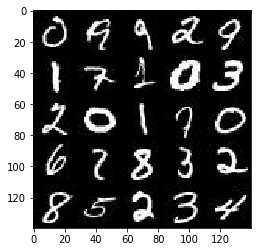

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

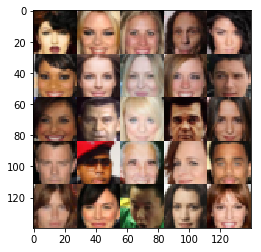

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """    
    
    # TODO: Implement Function
    alpha=0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha*x1, x1)
        
        #14x14x56
        x2 = tf.layers.conv2d(x1, 112, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        
        #7x7x112
        x3 = tf.layers.conv2d(x2, 224, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        
        flat = tf.reshape(x3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        x1 = tf.layers.dense(z, 7*7*112)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 112))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)        
        
        x2 = tf.layers.conv2d_transpose(x1, 56, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)                          
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')        
        
        out = tf.tanh(logits)

    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [36]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_inputs, z_inputs, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_inputs, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print_every = 10
    show_every = 100
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Normalize
                batch_images = batch_images * 2
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_inputs: batch_z, real_inputs: batch_images})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, z_inputs, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1576... Generator Loss: 2.4544
Epoch 1/2... Discriminator Loss: 0.1231... Generator Loss: 2.6932
Epoch 1/2... Discriminator Loss: 0.0927... Generator Loss: 3.1315
Epoch 1/2... Discriminator Loss: 0.1188... Generator Loss: 2.8355
Epoch 1/2... Discriminator Loss: 0.1214... Generator Loss: 2.5140
Epoch 1/2... Discriminator Loss: 0.0722... Generator Loss: 4.5945
Epoch 1/2... Discriminator Loss: 0.1019... Generator Loss: 3.2722
Epoch 1/2... Discriminator Loss: 0.0896... Generator Loss: 3.3924
Epoch 1/2... Discriminator Loss: 0.0898... Generator Loss: 3.5539
Epoch 1/2... Discriminator Loss: 0.0917... Generator Loss: 3.5279


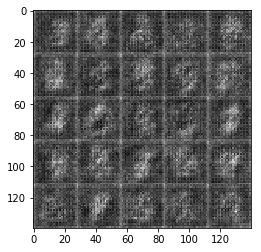

Epoch 1/2... Discriminator Loss: 1.8027... Generator Loss: 0.2892
Epoch 1/2... Discriminator Loss: 0.1551... Generator Loss: 3.4071
Epoch 1/2... Discriminator Loss: 0.2199... Generator Loss: 2.7262
Epoch 1/2... Discriminator Loss: 0.2232... Generator Loss: 2.8716
Epoch 1/2... Discriminator Loss: 0.1957... Generator Loss: 2.4672
Epoch 1/2... Discriminator Loss: 0.1888... Generator Loss: 2.6799
Epoch 1/2... Discriminator Loss: 0.1828... Generator Loss: 2.5404
Epoch 1/2... Discriminator Loss: 0.2070... Generator Loss: 2.7660
Epoch 1/2... Discriminator Loss: 0.3650... Generator Loss: 3.9560
Epoch 1/2... Discriminator Loss: 0.2167... Generator Loss: 2.6648


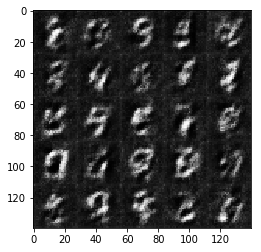

Epoch 1/2... Discriminator Loss: 0.2274... Generator Loss: 2.5201
Epoch 1/2... Discriminator Loss: 0.2543... Generator Loss: 2.4810
Epoch 1/2... Discriminator Loss: 0.4493... Generator Loss: 1.3550
Epoch 1/2... Discriminator Loss: 0.2634... Generator Loss: 2.0579
Epoch 1/2... Discriminator Loss: 0.2425... Generator Loss: 2.3013
Epoch 1/2... Discriminator Loss: 0.2782... Generator Loss: 2.2047
Epoch 1/2... Discriminator Loss: 1.5549... Generator Loss: 5.6692
Epoch 1/2... Discriminator Loss: 0.3083... Generator Loss: 1.9555
Epoch 1/2... Discriminator Loss: 0.2777... Generator Loss: 2.0788
Epoch 1/2... Discriminator Loss: 0.3730... Generator Loss: 1.5306


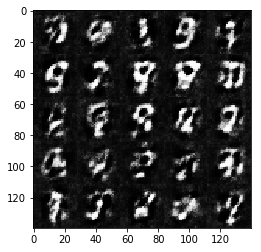

Epoch 1/2... Discriminator Loss: 0.3361... Generator Loss: 3.4252
Epoch 1/2... Discriminator Loss: 0.3382... Generator Loss: 3.2275
Epoch 1/2... Discriminator Loss: 0.2546... Generator Loss: 2.2272
Epoch 1/2... Discriminator Loss: 0.4300... Generator Loss: 1.3912
Epoch 1/2... Discriminator Loss: 0.2932... Generator Loss: 2.1635
Epoch 1/2... Discriminator Loss: 0.2723... Generator Loss: 2.1391
Epoch 1/2... Discriminator Loss: 0.2455... Generator Loss: 2.4259
Epoch 1/2... Discriminator Loss: 0.2877... Generator Loss: 2.2078
Epoch 1/2... Discriminator Loss: 0.3400... Generator Loss: 2.0687
Epoch 1/2... Discriminator Loss: 0.2894... Generator Loss: 2.0744


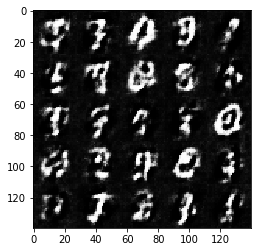

Epoch 1/2... Discriminator Loss: 0.3879... Generator Loss: 1.5552
Epoch 1/2... Discriminator Loss: 0.7200... Generator Loss: 4.2141
Epoch 1/2... Discriminator Loss: 0.2524... Generator Loss: 2.9442
Epoch 1/2... Discriminator Loss: 0.2632... Generator Loss: 2.4416
Epoch 1/2... Discriminator Loss: 0.2684... Generator Loss: 2.8343
Epoch 1/2... Discriminator Loss: 0.5785... Generator Loss: 1.0941
Epoch 2/2... Discriminator Loss: 0.2137... Generator Loss: 2.7653
Epoch 2/2... Discriminator Loss: 0.2072... Generator Loss: 2.7019
Epoch 2/2... Discriminator Loss: 0.2085... Generator Loss: 2.5997
Epoch 2/2... Discriminator Loss: 0.2206... Generator Loss: 2.5135


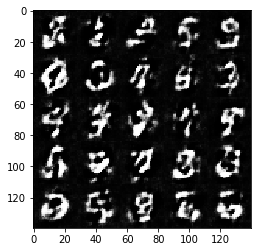

Epoch 2/2... Discriminator Loss: 0.2225... Generator Loss: 2.2551
Epoch 2/2... Discriminator Loss: 0.2153... Generator Loss: 2.8649
Epoch 2/2... Discriminator Loss: 0.9810... Generator Loss: 0.6455
Epoch 2/2... Discriminator Loss: 0.2511... Generator Loss: 2.6603
Epoch 2/2... Discriminator Loss: 0.3215... Generator Loss: 1.6938
Epoch 2/2... Discriminator Loss: 0.2497... Generator Loss: 2.2309
Epoch 2/2... Discriminator Loss: 0.2449... Generator Loss: 2.3407
Epoch 2/2... Discriminator Loss: 0.2440... Generator Loss: 1.9833
Epoch 2/2... Discriminator Loss: 1.5291... Generator Loss: 0.3277
Epoch 2/2... Discriminator Loss: 0.2594... Generator Loss: 2.2476


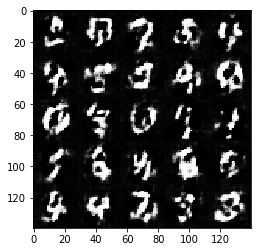

Epoch 2/2... Discriminator Loss: 0.2597... Generator Loss: 2.7363
Epoch 2/2... Discriminator Loss: 0.2346... Generator Loss: 2.8739
Epoch 2/2... Discriminator Loss: 0.2993... Generator Loss: 1.8039
Epoch 2/2... Discriminator Loss: 0.2554... Generator Loss: 3.3543
Epoch 2/2... Discriminator Loss: 0.2635... Generator Loss: 1.9269
Epoch 2/2... Discriminator Loss: 0.4686... Generator Loss: 1.3100
Epoch 2/2... Discriminator Loss: 0.2516... Generator Loss: 2.2429
Epoch 2/2... Discriminator Loss: 0.2130... Generator Loss: 3.0735
Epoch 2/2... Discriminator Loss: 0.1803... Generator Loss: 2.5637
Epoch 2/2... Discriminator Loss: 0.2007... Generator Loss: 2.4449


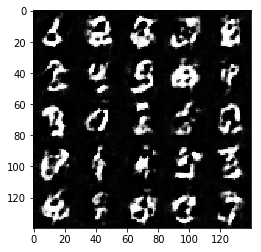

Epoch 2/2... Discriminator Loss: 0.1926... Generator Loss: 2.9074
Epoch 2/2... Discriminator Loss: 0.1747... Generator Loss: 2.5283
Epoch 2/2... Discriminator Loss: 0.2524... Generator Loss: 4.0081
Epoch 2/2... Discriminator Loss: 0.2028... Generator Loss: 3.1009
Epoch 2/2... Discriminator Loss: 0.1823... Generator Loss: 2.8573
Epoch 2/2... Discriminator Loss: 0.2013... Generator Loss: 2.9200
Epoch 2/2... Discriminator Loss: 0.1668... Generator Loss: 2.8261
Epoch 2/2... Discriminator Loss: 0.1788... Generator Loss: 2.6587
Epoch 2/2... Discriminator Loss: 0.2209... Generator Loss: 3.4012
Epoch 2/2... Discriminator Loss: 0.2573... Generator Loss: 4.1222


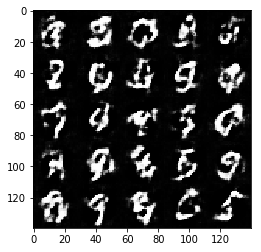

Epoch 2/2... Discriminator Loss: 0.1517... Generator Loss: 3.0425
Epoch 2/2... Discriminator Loss: 0.2518... Generator Loss: 2.7243
Epoch 2/2... Discriminator Loss: 0.1928... Generator Loss: 3.0223
Epoch 2/2... Discriminator Loss: 0.1689... Generator Loss: 2.6652
Epoch 2/2... Discriminator Loss: 0.1529... Generator Loss: 2.9071
Epoch 2/2... Discriminator Loss: 0.1631... Generator Loss: 2.7630
Epoch 2/2... Discriminator Loss: 0.2283... Generator Loss: 2.8409
Epoch 2/2... Discriminator Loss: 0.4157... Generator Loss: 4.5929
Epoch 2/2... Discriminator Loss: 0.1993... Generator Loss: 2.9423
Epoch 2/2... Discriminator Loss: 0.1800... Generator Loss: 2.4717


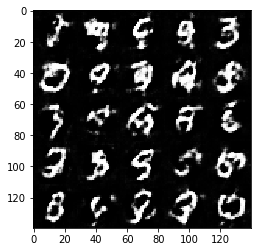

Epoch 2/2... Discriminator Loss: 0.2119... Generator Loss: 2.7810
Epoch 2/2... Discriminator Loss: 0.1935... Generator Loss: 3.0563
Epoch 2/2... Discriminator Loss: 0.1735... Generator Loss: 3.0996


In [37]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1399... Generator Loss: 2.5917
Epoch 1/1... Discriminator Loss: 0.1503... Generator Loss: 2.5492
Epoch 1/1... Discriminator Loss: 0.0596... Generator Loss: 3.7034
Epoch 1/1... Discriminator Loss: 0.0547... Generator Loss: 3.5765
Epoch 1/1... Discriminator Loss: 0.0401... Generator Loss: 4.1017
Epoch 1/1... Discriminator Loss: 0.0880... Generator Loss: 2.7791
Epoch 1/1... Discriminator Loss: 0.1401... Generator Loss: 3.7281
Epoch 1/1... Discriminator Loss: 0.4136... Generator Loss: 2.4308
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 1.5367


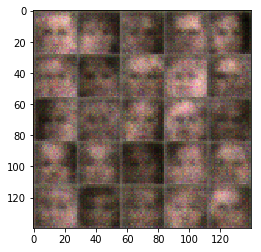

Epoch 1/1... Discriminator Loss: 0.4185... Generator Loss: 1.5342
Epoch 1/1... Discriminator Loss: 0.4444... Generator Loss: 3.7561
Epoch 1/1... Discriminator Loss: 0.3366... Generator Loss: 1.9592
Epoch 1/1... Discriminator Loss: 0.2971... Generator Loss: 2.5514
Epoch 1/1... Discriminator Loss: 0.3836... Generator Loss: 2.4121
Epoch 1/1... Discriminator Loss: 0.4575... Generator Loss: 1.3341
Epoch 1/1... Discriminator Loss: 0.2281... Generator Loss: 2.5160
Epoch 1/1... Discriminator Loss: 0.1994... Generator Loss: 3.0562
Epoch 1/1... Discriminator Loss: 0.3517... Generator Loss: 2.0773
Epoch 1/1... Discriminator Loss: 0.2539... Generator Loss: 2.9676


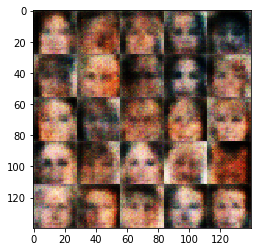

Epoch 1/1... Discriminator Loss: 0.3263... Generator Loss: 1.9416
Epoch 1/1... Discriminator Loss: 0.3197... Generator Loss: 2.1317
Epoch 1/1... Discriminator Loss: 0.4916... Generator Loss: 3.0282
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 0.3062... Generator Loss: 2.0813
Epoch 1/1... Discriminator Loss: 0.2668... Generator Loss: 2.0967
Epoch 1/1... Discriminator Loss: 0.2920... Generator Loss: 2.2681
Epoch 1/1... Discriminator Loss: 0.4032... Generator Loss: 1.5759
Epoch 1/1... Discriminator Loss: 3.2751... Generator Loss: 7.0080
Epoch 1/1... Discriminator Loss: 0.3703... Generator Loss: 1.6247


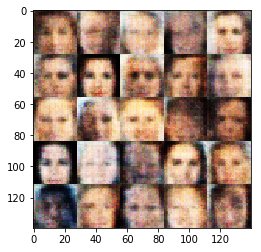

Epoch 1/1... Discriminator Loss: 0.4080... Generator Loss: 1.6979
Epoch 1/1... Discriminator Loss: 0.4540... Generator Loss: 1.3351
Epoch 1/1... Discriminator Loss: 0.4803... Generator Loss: 2.5845
Epoch 1/1... Discriminator Loss: 0.3245... Generator Loss: 2.6663
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 2.2972
Epoch 1/1... Discriminator Loss: 0.3207... Generator Loss: 2.0068
Epoch 1/1... Discriminator Loss: 0.3894... Generator Loss: 1.7453
Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 2.8826
Epoch 1/1... Discriminator Loss: 0.5447... Generator Loss: 1.3277
Epoch 1/1... Discriminator Loss: 0.6456... Generator Loss: 1.4567


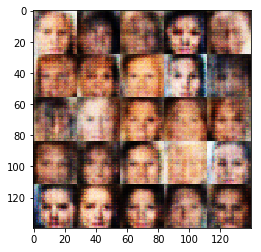

Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 1.9725
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 2.1336
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 2.5933
Epoch 1/1... Discriminator Loss: 0.4079... Generator Loss: 2.5656
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 0.4344... Generator Loss: 2.1993
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 0.3382... Generator Loss: 2.0104


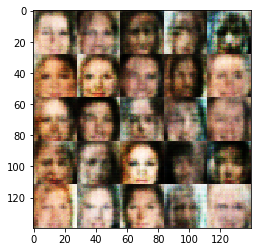

Epoch 1/1... Discriminator Loss: 1.8889... Generator Loss: 0.2611
Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 1.5577
Epoch 1/1... Discriminator Loss: 0.6054... Generator Loss: 1.8889
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 0.6551... Generator Loss: 1.2059
Epoch 1/1... Discriminator Loss: 0.5907... Generator Loss: 2.0784
Epoch 1/1... Discriminator Loss: 0.6517... Generator Loss: 1.1560
Epoch 1/1... Discriminator Loss: 0.7449... Generator Loss: 1.8354
Epoch 1/1... Discriminator Loss: 0.5348... Generator Loss: 1.9853
Epoch 1/1... Discriminator Loss: 0.5895... Generator Loss: 1.9446


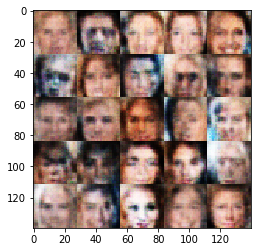

Epoch 1/1... Discriminator Loss: 0.7446... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 1.7400
Epoch 1/1... Discriminator Loss: 0.6725... Generator Loss: 1.1417
Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 0.5494... Generator Loss: 1.7875
Epoch 1/1... Discriminator Loss: 0.7146... Generator Loss: 1.3091
Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 2.4167
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 1.7647
Epoch 1/1... Discriminator Loss: 0.6963... Generator Loss: 1.8889


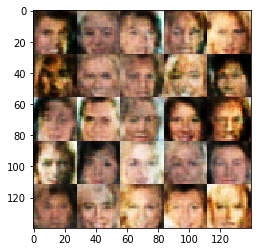

Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 2.2033
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 1.7989
Epoch 1/1... Discriminator Loss: 0.5711... Generator Loss: 1.9203
Epoch 1/1... Discriminator Loss: 0.6558... Generator Loss: 1.3291
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 2.6488
Epoch 1/1... Discriminator Loss: 0.7218... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 1.8263
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 0.7155... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 0.8788


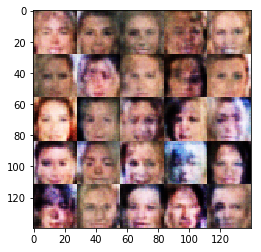

Epoch 1/1... Discriminator Loss: 0.6030... Generator Loss: 1.3155
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 2.7227
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 2.0186
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 1.5579
Epoch 1/1... Discriminator Loss: 0.5967... Generator Loss: 1.6473
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 0.6678... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 0.7794... Generator Loss: 2.4276
Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 1.1135


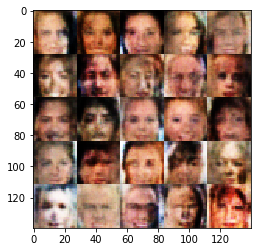

Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 1.5395
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 1.2030
Epoch 1/1... Discriminator Loss: 0.5974... Generator Loss: 1.6065
Epoch 1/1... Discriminator Loss: 0.4771... Generator Loss: 1.5786
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 3.8098... Generator Loss: 0.0492
Epoch 1/1... Discriminator Loss: 0.6009... Generator Loss: 1.2512
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 0.4749... Generator Loss: 1.7234
Epoch 1/1... Discriminator Loss: 0.5453... Generator Loss: 1.8240


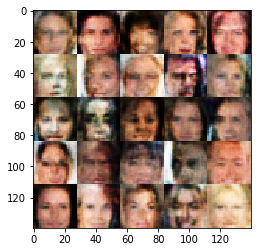

Epoch 1/1... Discriminator Loss: 0.5386... Generator Loss: 1.5275
Epoch 1/1... Discriminator Loss: 0.6457... Generator Loss: 1.2373
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 0.4959... Generator Loss: 1.4023
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 0.6251... Generator Loss: 1.1590
Epoch 1/1... Discriminator Loss: 0.6419... Generator Loss: 2.2878
Epoch 1/1... Discriminator Loss: 0.5006... Generator Loss: 1.6174
Epoch 1/1... Discriminator Loss: 0.5546... Generator Loss: 1.6607
Epoch 1/1... Discriminator Loss: 0.8843... Generator Loss: 0.7277


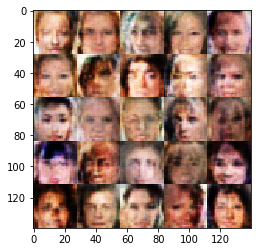

Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 1.2767
Epoch 1/1... Discriminator Loss: 0.6032... Generator Loss: 1.4432
Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 1.3934
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 0.5823... Generator Loss: 1.3822
Epoch 1/1... Discriminator Loss: 0.5228... Generator Loss: 1.5579
Epoch 1/1... Discriminator Loss: 0.6493... Generator Loss: 1.3798
Epoch 1/1... Discriminator Loss: 0.7892... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 0.6807... Generator Loss: 0.9602


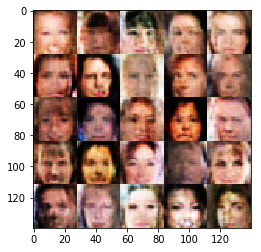

Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 1.4312
Epoch 1/1... Discriminator Loss: 0.4839... Generator Loss: 1.4041
Epoch 1/1... Discriminator Loss: 0.5256... Generator Loss: 1.2449
Epoch 1/1... Discriminator Loss: 0.4896... Generator Loss: 1.7069
Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 1.5447
Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 1.3381
Epoch 1/1... Discriminator Loss: 1.8297... Generator Loss: 3.7893
Epoch 1/1... Discriminator Loss: 0.8633... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 0.7274... Generator Loss: 0.8492


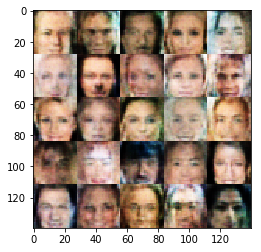

Epoch 1/1... Discriminator Loss: 0.4737... Generator Loss: 1.6407
Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 2.5049
Epoch 1/1... Discriminator Loss: 0.5598... Generator Loss: 1.2465
Epoch 1/1... Discriminator Loss: 0.4349... Generator Loss: 1.6000
Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 2.1437
Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 1.6496
Epoch 1/1... Discriminator Loss: 0.5260... Generator Loss: 1.4250
Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 1.2774


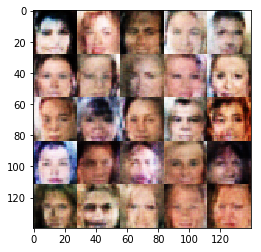

Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 0.4219... Generator Loss: 1.5746
Epoch 1/1... Discriminator Loss: 0.5143... Generator Loss: 1.6757
Epoch 1/1... Discriminator Loss: 0.3408... Generator Loss: 1.9177
Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 1.4700
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 2.8660
Epoch 1/1... Discriminator Loss: 0.6003... Generator Loss: 1.4789
Epoch 1/1... Discriminator Loss: 0.5448... Generator Loss: 1.4640
Epoch 1/1... Discriminator Loss: 0.6884... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 0.9090


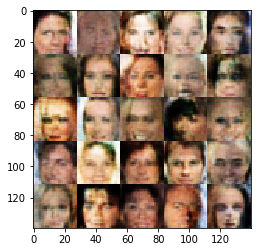

Epoch 1/1... Discriminator Loss: 0.3785... Generator Loss: 1.8805
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 3.1706
Epoch 1/1... Discriminator Loss: 0.3793... Generator Loss: 1.9308
Epoch 1/1... Discriminator Loss: 0.4999... Generator Loss: 1.4128
Epoch 1/1... Discriminator Loss: 0.6053... Generator Loss: 1.1135
Epoch 1/1... Discriminator Loss: 0.2805... Generator Loss: 2.0658
Epoch 1/1... Discriminator Loss: 0.5359... Generator Loss: 1.2848
Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 1.5019


In [39]:
batch_size = 128
z_dim = 150
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.